In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

First, I am going to copy/paste all of the code from the curriculum so we can see what they were getting after before I implement my new code.

In [2]:
# Acquire, load, and preview the data.
data = pd.read_csv('..//Advertising.csv')
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['sales'].values.reshape(-1, 1)
X = data[['TV','radio','newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [ 2.93888937]

R-squared:
0.897210638179


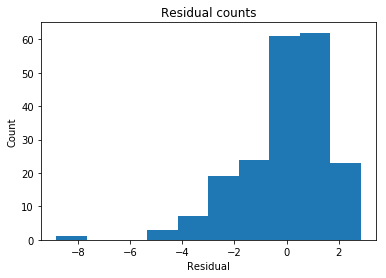

In [3]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

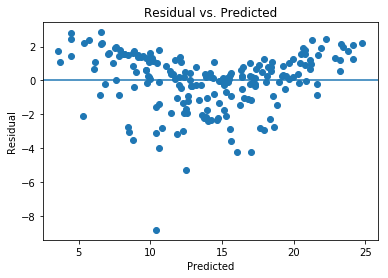

In [4]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.

In [5]:
correlation_matrix = X.corr()
display(correlation_matrix)

,TV,radio,newspaper
TV,1.000,0.055,0.057
radio,0.055,1.000,0.354
newspaper,0.057,0.354,1.000


According to the final cell in the curriculum, we have a problem with both heteroscedascity and multivariate non-normality. Let's fix those problems, shall we?

The first thing I want to address is the homoscedascity. It is clear from the plot that our predictor is not capturing the parabola like nature of the actual data. There is a non-linear relationship that we are not predicting, and my first thought is to add squared features to the data.

Which features to square, though? I have an idea of how regression works, so I think that if we square all of the features, our resulting coefficients will only keep them if they are important (i.e. coefficients of zero if it has no effect on the sales variable).

In [48]:
data['tv_sqrt'] = np.sqrt(data.TV)
data['tv_sq'] = data.TV**.4
data['tv_log'] = np.log(data.TV)
data['tv_exp'] = np.exp((data.TV - data.TV.mean())/data.TV.std())
data['radio_sqrt'] = np.sqrt(data.radio)
data['radio_sq'] = data.radio**2
data['radio_log'] = np.log(data.radio)
data['total_ads'] = data.TV + data.radio + data.newspaper
data['sales_'] = data['sales']
data.head()

C:\Users\bretw\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


,Unnamed: 0,TV,radio,newspaper,sales,tv_sqrt,tv_sq,radio_sq,sales_,radio_sqrt,tv_log,radio_log,tv_exp,total_ads
0,1,230.100,37.800,69.200,22.100,15.169,8.806,1428.840,22.100,6.148,5.439,3.632,2.631,337.100
1,2,44.500,39.300,45.100,10.400,6.671,4.564,1544.490,10.400,6.269,3.795,3.671,0.303,128.900
2,3,17.200,45.900,69.300,9.300,4.147,3.120,2106.810,9.300,6.775,2.845,3.826,0.220,132.400
3,4,151.500,41.300,58.500,18.500,12.309,7.450,1705.690,18.500,6.427,5.021,3.721,1.053,251.300
4,5,180.800,10.800,58.400,12.900,13.446,7.996,116.640,12.900,3.286,5.197,2.380,1.482,250.000


C:\Users\bretw\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


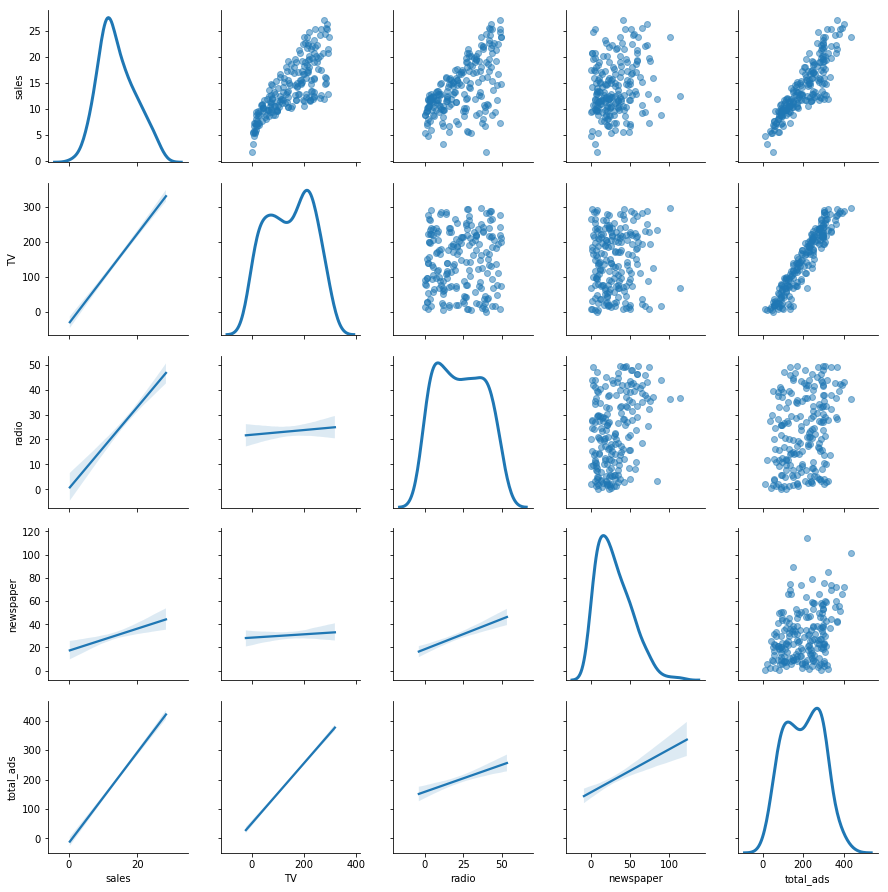

In [49]:
g = sns.PairGrid(data.loc[:, ['sales', 'TV', 'radio', 'newspaper', 'total_ads']], diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

C:\Users\bretw\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


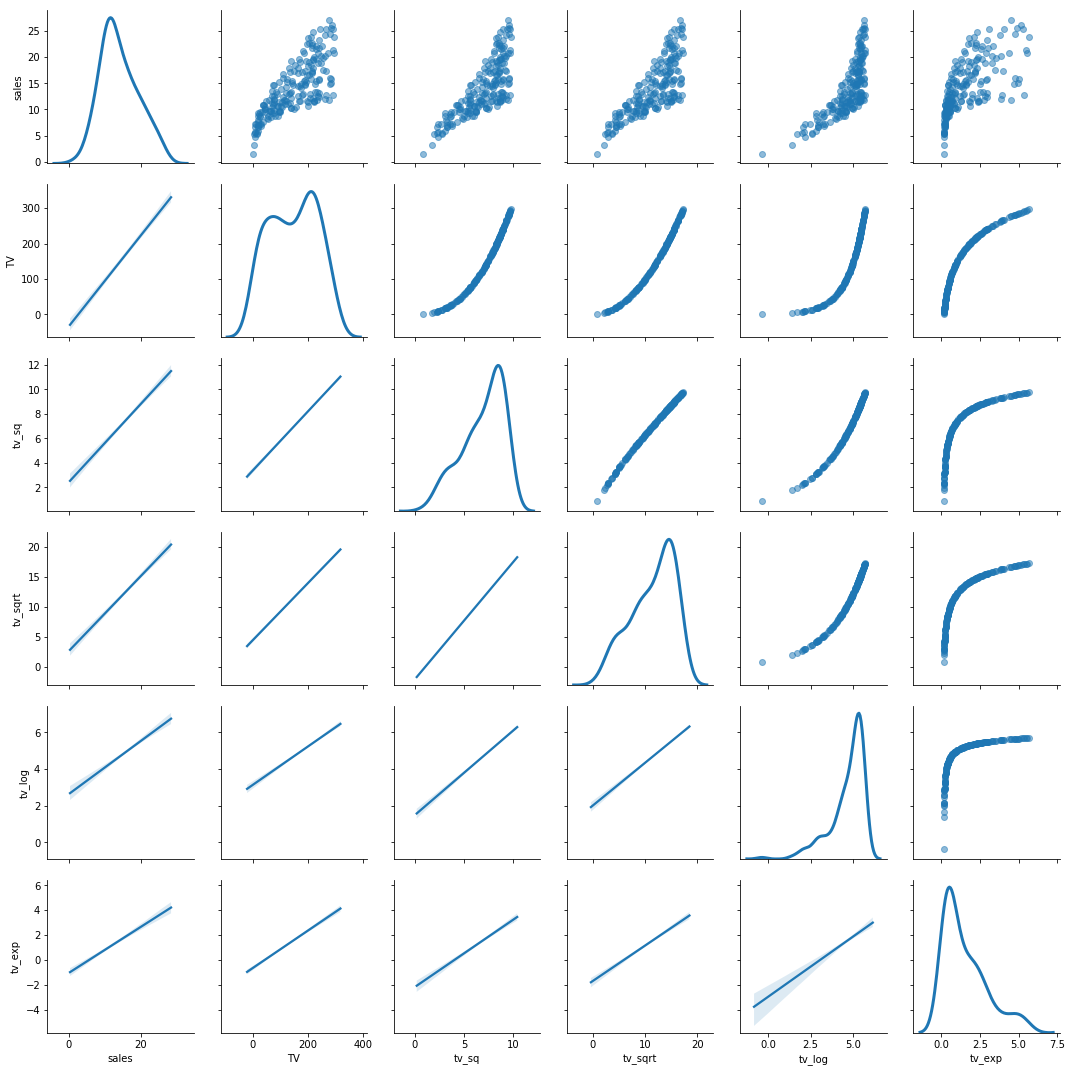

In [47]:
g = sns.PairGrid(data.loc[:, ['sales', 'TV', 'tv_sq', 'tv_sqrt', 'tv_log', 'tv_exp']], diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

C:\Users\bretw\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


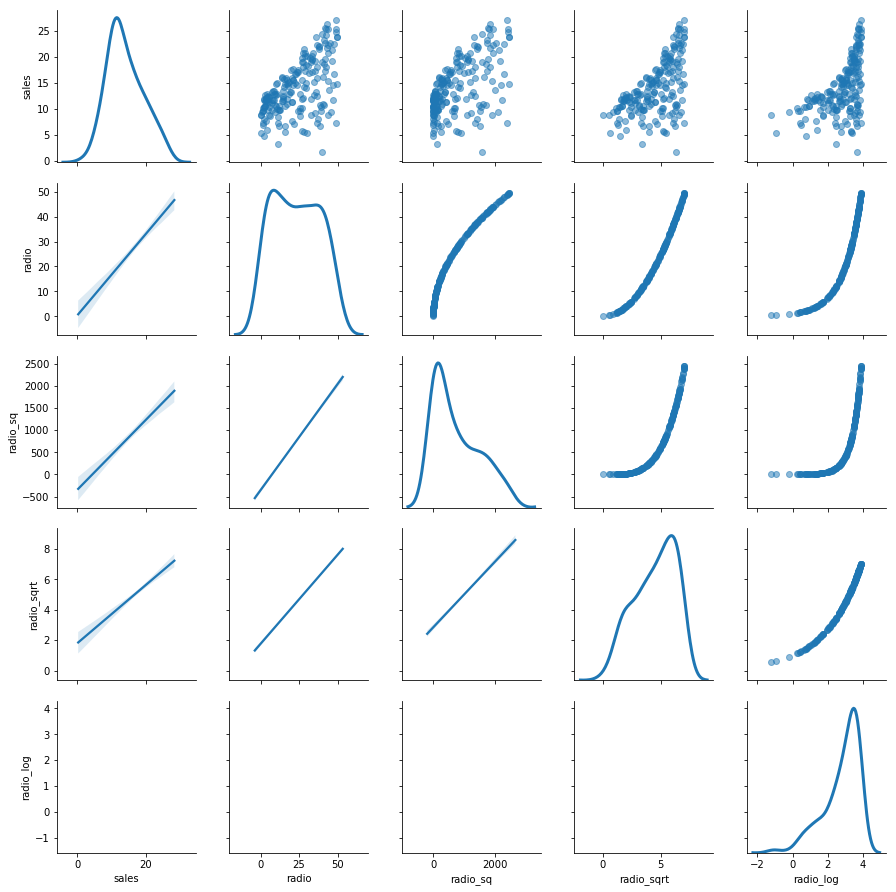

In [27]:
g = sns.PairGrid(data.loc[:, ['sales', 'radio', 'radio_sq', 'radio_sqrt', 'radio_log']], diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

Let's now rerun the regression using similar code to before


Coefficients: 
 [[  1.92258852e+00   1.97017016e-01  -4.17125000e-04]]

Intercept: 
 [-3.78075989]

R-squared:
0.931315589522


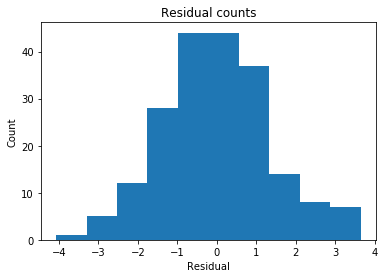

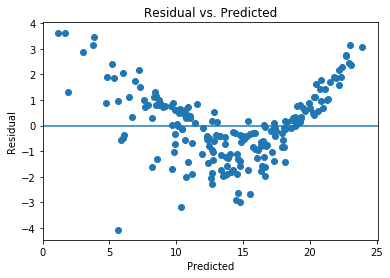

In [50]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['sales'].values.reshape(-1, 1)
X = data[['tv_sq', 'radio', 'total_ads']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['sales']

# Calculate the error, also called the residual.
residual = actual - predicted


plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [51]:
correlation_matrix = X.corr()
display(correlation_matrix)

,tv_sq,radio,total_ads
tv_sq,1.000,0.023,0.910
radio,0.023,1.000,0.293
total_ads,0.910,0.293,1.000
